# Understanding YOLO Output

## Yolo output have 3 scale and each scale have 3 anchor
(x,y, (anchor*5+class) )
(x,y,anchor,5+class) 5 - > consist of (x,y,w,h,conf)

In [248]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

In [249]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [265]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            #if i==0:
            #    print("random")
            #    np.random.shuffle(annotation_lines)
            print(annotation_lines[i])
            image, box = get_random_data(annotation_lines[i], input_shape, random=False)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [266]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1

#train_lines

In [267]:

        # create an hdf5 file
train_size = 5 #len(train_lines)
image = {}
box = {}
train_logits = {}
model_logits = {}

print( "total "+ str(len(train_lines)) + " loop "+ str( train_size ) )

i = 0 #step
for  img,box_data,flogits,mlogits in data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model) : 
    #x , y = dat
    image[i] = img
    box[i] = box_data
    train_logits[i] = flogits
    model_logits[i] = mlogits

    i+=1
    if i>= train_size:#(len(train_lines)) :
        break

total 2501 loop 5
D:\FinalProject\ComputerVision\yolov3_keras/VOCdevkit/VOC2007/JPEGImages/000012.jpg 156,97,351,270,6

D:\FinalProject\ComputerVision\yolov3_keras/VOCdevkit/VOC2007/JPEGImages/000017.jpg 185,62,279,199,14 90,78,403,336,12

D:\FinalProject\ComputerVision\yolov3_keras/VOCdevkit/VOC2007/JPEGImages/000023.jpg 9,230,245,500,1 230,220,334,500,1 2,1,117,369,14 3,2,243,462,14 225,1,334,486,14

D:\FinalProject\ComputerVision\yolov3_keras/VOCdevkit/VOC2007/JPEGImages/000026.jpg 90,125,337,212,6

D:\FinalProject\ComputerVision\yolov3_keras/VOCdevkit/VOC2007/JPEGImages/000032.jpg 104,78,375,183,0 133,88,197,123,0 195,180,213,229,14 26,189,44,238,14



In [255]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [256]:
ch = 0
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [257]:
box[ch]

array([[[106.,   0., 254., 416.,  14.],
        [281.,   0., 346., 204.,  14.],
        [136.,  29., 286., 416.,  14.],
        [239.,   0., 278.,  35.,  14.],
        [278.,  70., 346., 416.,  14.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

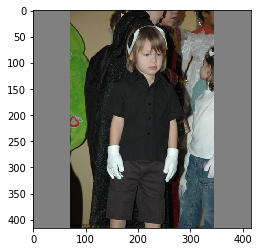

In [258]:
plt.imshow(image[ch][0])
plt.show()

In [210]:
train_logits[ch][0].shape

(1, 13, 13, 3, 25)

In [211]:
train_logits[ch][1].shape

(1, 26, 26, 3, 25)

In [212]:
train_logits[ch][2].shape

(1, 52, 52, 3, 25)

In [213]:
np.set_printoptions(threshold=np.inf)

### Real Dataset

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [214]:
lrg = train_logits[ch][0]
med = train_logits[ch][1]
sml = train_logits[ch][2]

In [215]:
lrgm = model_logits[ch][0]
medm = model_logits[ch][1]
smlm = model_logits[ch][2]

Change the Variable to see other scale

In [216]:
arrpl = lrg
arrpl[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxl = np.where(arrpl[:,:,:,:,4] > 0 )
boxl

(array([0, 0], dtype=int64),
 array([7, 7], dtype=int64),
 array([3, 8], dtype=int64),
 array([1, 0], dtype=int64))

x,y,w,h,p and class

In [217]:
box = boxl
arrp= arrpl
for i in range(len(box[0])):
    s = np.array(box)
    #print( i*5 )
    stp = i
   
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

(0,7,3,1)
[0.23557693 0.5504808  0.47115386 0.64903843 1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
14 = person
-------------------------------------------------------
(0,7,8,0)
[0.62259614 0.56009614 0.20432693 0.19471154 1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
19 = tvmonitor
-------------------------------------------------------


In [218]:
arrpm = med
boxm = np.where(arrpm[:,:,:,:,4] > 0 )
boxm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [219]:
box = boxm
arrp= arrpm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

In [220]:
arrps = sml
boxs = np.where(arrps[:,:,:,:,4] > 0 )
boxs

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [221]:
box = boxs
arrp= arrps
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

### Model Predict

In [222]:
import math
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

def sigmoid(x):
        """sigmoid.

        # Arguments
            x: Tensor.

        # Returns
            numpy ndarray.
        """
        return 1 / (1 + np.exp(-x))
    

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

Change the Variable to see other scale

In [223]:
arrplm = lrgm
arrplm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxlm = np.where(arrplm[:,:,:,:,4] > 0 )
boxlm

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([6, 6, 6, 6, 7, 7, 7, 7, 7, 7], dtype=int64),
 array([2, 2, 3, 3, 2, 2, 3, 3, 7, 8], dtype=int64),
 array([1, 2, 1, 2, 1, 2, 1, 2, 0, 0], dtype=int64))

x,y,w,h,p and class

In [224]:
from keras import backend as K

box = boxlm
arrp= arrplm
for i in range(len(box[0])  ):
    s = np.array(box)
    #print( i*5 )
    stp = i
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    objprob = arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]
    print( objprob )
   # print( softmax(objprob) )
    obnum =  np.argmax( objprob ) 
    objsum = sum(objprob)
    #print(sum(softmax(objprob)))
    #print("sigmoid")
    #box_confidence = sigmoid( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp], 4:5])
    #box_class_probs = sigmoid(arrp[ s[0,stp],s[1,stp],s[2,stp],s[3,stp], 5:])
    #print( "conf = {} prob > {}".format( box_confidence , box_class_probs ))
    #print("--------------------------")
    print( "{} = {} sum > {}".format(obnum, obj[ obnum ],objsum ) )
    print("-------------------------------------------------------")

(0,6,2,1)
[1.8467679  2.269439   0.26651886 0.31183854 6.1703243 ]
[-12.2759905 -13.605868  -13.867165  -13.045496  -11.306467  -12.142809
 -15.077707  -15.896837  -10.424463  -15.690822  -10.897114  -11.845965
 -12.277764  -14.207172    8.805417  -13.147141  -15.334028  -10.048749
 -10.666689  -13.803399 ]
[6.98973990e-10 1.84885302e-10 1.42371448e-10 3.23794186e-10
 1.84297611e-09 7.98548061e-10 4.24317421e-11 1.87045501e-11
 4.45214265e-09 2.29836341e-11 2.77523382e-09 1.07453002e-09
 6.97735203e-10 1.01334975e-10 1.00000000e+00 2.92499386e-10
 3.28376527e-11 6.48245813e-09 3.49439366e-09 1.51745519e-10]
14 = person sum > -236.75623035430908
-------------------------------------------------------
(0,6,2,2)
[ 1.7204169  1.5927573 -0.6061329 -0.1252854  1.8024995]
[-12.546714  -11.103511  -11.063769  -13.550654  -11.1074     -6.942869
 -12.511078  -14.0862875 -10.585325  -12.851891  -10.408863  -12.420497
 -10.261856  -11.4520645   8.081602  -11.198068  -11.566492   -9.275841
 -11.445

In [225]:
arrpmm = medm
arrpmm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxmm = np.where(arrpmm[:,:,:,:,4] > 0 )
boxmm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

x,y,w,h,p and class

In [226]:
box = boxmm
arrp= arrpmm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
 
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

In [227]:
arrpsm = smlm
arrpsm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxsm = np.where(arrpsm[:,:,:,:,4] > 0 )
boxsm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

x,y,w,h,p and class

In [228]:
box = boxsm
arrp= arrpsm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
   
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

Adjust the Model

In [229]:
lrga = model_logits[ch][0]
meda = model_logits[ch][1]
smla = model_logits[ch][2]

In [230]:
arrpa = lrga
arrpa[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
#boxa = np.where(arrpa[:,:,:,:,4] > 0 )
#boxa
arrpa[...,:2]

array([[[[[ 9.35567439e-01, -7.46709883e-01],
          [ 5.74295878e-01,  5.02408683e-01],
          [ 1.24237800e+00, -1.26163352e+00]],

         [[ 6.67312682e-01,  5.99482000e-01],
          [ 9.20214057e-01, -1.24550164e-01],
          [ 3.38623077e-01, -7.10611582e-01]],

         [[-2.86566436e-01,  8.61859024e-01],
          [-5.46377301e-01,  5.53215504e-01],
          [ 1.01375651e+00,  2.36505121e-01]],

         [[ 4.35467772e-02,  5.28045535e-01],
          [-1.53368890e-01,  2.72081345e-01],
          [ 7.39729404e-01,  4.36972558e-01]],

         [[-1.76552311e-01,  6.85170352e-01],
          [-4.38345000e-02,  5.71558058e-01],
          [ 4.24638927e-01,  4.97541070e-01]],

         [[-2.21143559e-01,  5.84959149e-01],
          [-1.36982977e-01,  7.83528924e-01],
          [ 2.69858867e-01,  6.49537563e-01]],

         [[-2.77857631e-01,  6.14443839e-01],
          [-1.96982712e-01,  6.16556823e-01],
          [-1.52607691e-02,  6.72779381e-01]],

         [[-4.956727

In [231]:
box_xy = sigmoid(arrpa[...,:2])
box_xy

array([[[[[0.7182034 , 0.32153863],
          [0.6397538 , 0.6230252 ],
          [0.7759777 , 0.22069281]],

         [[0.6609011 , 0.6455378 ],
          [0.71508574, 0.46890262],
          [0.58385605, 0.32946372]],

         [[0.42884466, 0.7030489 ],
          [0.3667053 , 0.6348813 ],
          [0.7337547 , 0.5588522 ]],

         [[0.510885  , 0.6290271 ],
          [0.46173277, 0.5676038 ],
          [0.6769367 , 0.6075374 ]],

         [[0.45597622, 0.66489166],
          [0.48904315, 0.6391226 ],
          [0.60459274, 0.6218813 ]],

         [[0.4449383 , 0.6422077 ],
          [0.4658077 , 0.68644017],
          [0.56705827, 0.65690625]],

         [[0.4309791 , 0.6489538 ],
          [0.45091295, 0.64943504],
          [0.4961849 , 0.6621253 ]],

         [[0.37855813, 0.6576989 ],
          [0.42828345, 0.6671364 ],
          [0.45205298, 0.68251204]],

         [[0.36864316, 0.7068127 ],
          [0.399565  , 0.6491353 ],
          [0.37708935, 0.5862476 ]],

         [

In [232]:
arrpa[..., 2:4]

array([[[[[-0.06122849,  0.12719612],
          [-0.2618095 ,  0.32136258],
          [ 0.00100813,  0.08292073]],

         [[ 0.11847003,  0.1462112 ],
          [-0.22809835,  0.5050731 ],
          [-0.34688973,  0.1208239 ]],

         [[ 0.39529064, -0.11990377],
          [-0.10135856,  0.3147458 ],
          [-0.19805598, -0.31020564]],

         [[ 0.47407264, -0.08045428],
          [-0.03961906,  0.33589536],
          [-0.23474401, -0.18625994]],

         [[ 0.5467883 ,  0.15601785],
          [ 0.10346472,  0.2678508 ],
          [-0.22712836, -0.2928783 ]],

         [[ 0.54200965,  0.19404285],
          [ 0.14011344,  0.21157406],
          [-0.11502868, -0.3161132 ]],

         [[ 0.5814321 ,  0.28933564],
          [ 0.1305977 ,  0.21706787],
          [-0.14570756, -0.34963894]],

         [[ 0.64513826,  0.3869292 ],
          [ 0.15649278,  0.21644966],
          [-0.06474203, -0.26744464]],

         [[ 0.5614823 ,  0.24522074],
          [ 0.21233435,  0.1949159

In [233]:
box_wh = np.exp(arrpa[..., 2:4])
box_wh

array([[[[[0.9406083 , 1.1356397 ],
          [0.7696576 , 1.3790056 ],
          [1.0010086 , 1.0864557 ]],

         [[1.1257732 , 1.1574407 ],
          [0.79604596, 1.6571066 ],
          [0.70688325, 1.1284262 ]],

         [[1.4848157 , 0.8870058 ],
          [0.903609  , 1.3699111 ],
          [0.82032394, 0.73329616]],

         [[1.6065236 , 0.92269707],
          [0.96115553, 1.3991926 ],
          [0.7907733 , 0.8300578 ]],

         [[1.7276952 , 1.1688471 ],
          [1.1090066 , 1.307152  ],
          [0.7968185 , 0.74611294]],

         [[1.7194589 , 1.2141483 ],
          [1.1504043 , 1.2356215 ],
          [0.89134055, 0.7289769 ]],

         [[1.7885981 , 1.3355399 ],
          [1.1395092 , 1.2424284 ],
          [0.86441046, 0.7049426 ]],

         [[1.9062506 , 1.4724523 ],
          [1.1694024 , 1.2416606 ],
          [0.9373092 , 0.7653327 ]],

         [[1.7532694 , 1.2779033 ],
          [1.2365613 , 1.2152089 ],
          [0.8657436 , 0.8990476 ]],

         [

In [234]:
arrpa[..., 4]

array([[[[-10.547356  , -11.441543  , -14.749247  ],
         [-12.023429  , -11.259772  , -13.55385   ],
         [-11.518597  , -11.336891  , -12.725702  ],
         [-12.702317  , -12.458174  , -13.921543  ],
         [-12.862362  , -12.9974375 , -13.3758955 ],
         [-12.458144  , -13.052994  , -13.626362  ],
         [-12.072816  , -12.215225  , -13.336697  ],
         [-11.3832855 , -12.048348  , -13.216028  ],
         [-11.606232  , -11.58233   , -14.893065  ],
         [-12.841623  , -12.227726  , -14.875018  ],
         [-10.584525  , -12.3160305 , -11.658031  ],
         [-11.251139  , -11.713033  , -11.063825  ],
         [-11.032672  , -11.096872  , -11.101899  ]],

        [[-12.322184  , -12.094553  , -13.75976   ],
         [-11.633702  , -13.111083  , -14.535646  ],
         [-13.314148  , -13.667811  , -14.401057  ],
         [-15.738818  , -14.794941  , -16.126951  ],
         [-15.996835  , -14.534071  , -14.924756  ],
         [-15.1041355 , -14.040795  , -14.39

In [235]:
box_confidence = sigmoid(arrpa[..., 4])
#box_confidence = np.expand_dims(box_confidence, axis=-1)
box_confidence

array([[[[2.62621470e-05, 1.07398073e-05, 3.93082217e-07],
         [6.00189696e-06, 1.28806396e-05, 1.29908358e-06],
         [9.94335005e-06, 1.19246470e-05, 2.97369502e-06],
         [3.04405421e-06, 3.88581566e-06, 8.99394536e-07],
         [2.59385729e-06, 2.26612383e-06, 1.55210728e-06],
         [3.88593025e-06, 2.14365991e-06, 1.20821915e-06],
         [5.71268401e-06, 4.95442146e-06, 1.61415619e-06],
         [1.13840551e-05, 5.85418184e-06, 1.82117242e-06],
         [9.10906147e-06, 9.32940748e-06, 3.40426766e-07],
         [2.64821165e-06, 4.89287322e-06, 3.46626337e-07],
         [2.53039416e-05, 4.47933962e-06, 8.64923095e-06],
         [1.29923255e-05, 8.18636272e-06, 1.56687802e-05],
         [1.61645803e-05, 1.51594340e-05, 1.50834239e-05]],

        [[4.45186242e-06, 5.58984721e-06, 1.05733284e-06],
         [8.86223916e-06, 2.02268438e-06, 4.86685906e-07],
         [1.65096662e-06, 1.15916271e-06, 5.56801069e-07],
         [1.46122815e-07, 3.75524792e-07, 9.91183455e-

In [236]:
arrpa[..., 5:]

array([[[[[-1.23244991e+01, -5.10359764e+00, -1.11749706e+01,
           -1.13570118e+01, -9.51336384e+00, -7.06116104e+00,
           -1.05388002e+01, -8.63149834e+00, -3.97993541e+00,
           -9.11009502e+00, -1.07888861e+01, -1.07062826e+01,
           -9.11903477e+00, -9.28873062e+00, -4.92743635e+00,
           -7.98872566e+00, -8.69823074e+00, -1.04248295e+01,
           -1.09179144e+01, -6.93256569e+00],
          [-1.01906986e+01, -4.63517284e+00, -8.74740982e+00,
           -1.26614094e+01, -7.90761900e+00, -9.27479935e+00,
           -1.11631947e+01, -9.37113380e+00, -5.08783007e+00,
           -1.06448364e+01, -9.45565128e+00, -9.42827606e+00,
           -1.18650322e+01, -1.04493484e+01, -2.02359033e+00,
           -9.68753147e+00, -1.17283335e+01, -8.20805073e+00,
           -9.93251610e+00, -9.26895618e+00],
          [-8.98692799e+00, -3.61617970e+00, -7.57816696e+00,
           -7.39983797e+00, -8.78855419e+00, -5.16799259e+00,
           -4.92964411e+00, -7.40121889e

In [237]:
box_class_probs = sigmoid(arrpa[..., 5:])
box_class_probs

array([[[[[4.44156558e-06, 6.03817077e-03, 1.40205748e-05,
           1.16871170e-05, 7.38527233e-05, 8.57046398e-04,
           2.64877890e-05, 1.78365328e-04, 1.83440540e-02,
           1.10531997e-04, 2.06270615e-05, 2.24032392e-05,
           1.09548368e-04, 9.24518099e-05, 7.19293999e-03,
           3.39151098e-04, 1.66852959e-04, 2.96852832e-05,
           1.81301821e-05, 9.74544208e-04],
          [3.75162599e-05, 9.61115863e-03, 1.58847062e-04,
           3.17116178e-06, 3.67794273e-04, 9.37486693e-05,
           1.41866549e-05, 8.51395380e-05, 6.13354426e-03,
           2.38229713e-05, 7.82400020e-05, 8.04112497e-05,
           7.03200112e-06, 2.89663021e-05, 1.16748244e-01,
           6.20485444e-05, 8.06205935e-06, 2.72377074e-04,
           4.85670753e-05, 9.42980114e-05],
          [1.25017978e-04, 2.61813011e-02, 5.11236489e-04,
           6.10978284e-04, 1.52445005e-04, 5.66373114e-03,
           7.17719086e-03, 6.10135670e-04, 7.91942351e-04,
           8.55665203e-05, 

In [238]:
newa = arrpa
newa[...,:2] = box_xy 
newa[..., 2:4] = box_wh
newa[..., 4] = box_confidence
newa[..., 5:] = box_class_probs

newa


array([[[[[7.18203425e-01, 3.21538627e-01, 9.40608323e-01,
           1.13563967e+00, 2.62621470e-05, 4.44156558e-06,
           6.03817077e-03, 1.40205748e-05, 1.16871170e-05,
           7.38527233e-05, 8.57046398e-04, 2.64877890e-05,
           1.78365328e-04, 1.83440540e-02, 1.10531997e-04,
           2.06270615e-05, 2.24032392e-05, 1.09548368e-04,
           9.24518099e-05, 7.19293999e-03, 3.39151098e-04,
           1.66852959e-04, 2.96852832e-05, 1.81301821e-05,
           9.74544208e-04],
          [6.39753819e-01, 6.23025179e-01, 7.69657612e-01,
           1.37900555e+00, 1.07398073e-05, 3.75162599e-05,
           9.61115863e-03, 1.58847062e-04, 3.17116178e-06,
           3.67794273e-04, 9.37486693e-05, 1.41866549e-05,
           8.51395380e-05, 6.13354426e-03, 2.38229713e-05,
           7.82400020e-05, 8.04112497e-05, 7.03200112e-06,
           2.89663021e-05, 1.16748244e-01, 6.20485444e-05,
           8.06205935e-06, 2.72377074e-04, 4.85670753e-05,
           9.42980114e-05],


Combined Box

In [239]:
arrpan = newa
arrpan[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxan = np.where(arrpan[:,:,:,:,4] > 0.3 )
boxan

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([6, 6, 6, 6, 7, 7, 7, 7, 7, 7], dtype=int64),
 array([2, 2, 3, 3, 2, 2, 3, 3, 7, 8], dtype=int64),
 array([1, 2, 1, 2, 1, 2, 1, 2, 0, 0], dtype=int64))

In [240]:
box = boxan
arrp= arrpan
for i in range(len(box[0])  ):
    s = np.array(box)
    #print( i*5 )
    stp = i
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    objprob = arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]
    print( objprob )
    obnum =  np.argmax( objprob ) 
    print( "{} = {} sum ".format(obnum, obj[ obnum ]) )
    print("-------------------------------------------------------")

(0,6,2,1)
[0.8637472  0.90631413 1.3054122  1.3659341  0.9979138 ]
[4.6623304e-06 1.2332353e-06 9.4965645e-07 2.1597932e-06 1.2293015e-05
 5.3265103e-06 2.8303151e-07 1.2476457e-07 2.9696153e-05 1.5330724e-07
 1.8511242e-05 7.1673644e-06 4.6540677e-06 6.7593220e-07 9.9985003e-01
 1.9510489e-06 2.1903629e-07 4.3237942e-05 2.3308039e-05 1.0121842e-06]
14 = person sum 
-------------------------------------------------------
(0,6,2,2)
[0.8481825  0.83100367 0.5454561  0.88224506 0.8584529 ]
[3.5565577e-06 1.5059133e-05 1.5669648e-05 1.3032418e-06 1.5000681e-05
 9.6456415e-04 3.6855843e-06 7.6278604e-07 2.5283704e-05 2.6211612e-06
 3.0163041e-05 4.0350133e-06 3.4939556e-05 1.0627398e-05 9.9969089e-01
 1.3700457e-05 9.4783381e-06 9.3651099e-05 1.0692991e-05 5.7298216e-06]
14 = person sum 
-------------------------------------------------------
(0,6,3,1)
[0.15641232 0.90041256 1.2313497  1.3634651  0.999376  ]
[1.4974962e-06 2.5126502e-07 6.8543363e-07 2.9052030e-06 1.9297222e-06
 4.9239829e-

In [244]:
combine = train_logits[ch][0]
combine

array([[[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+0

In [245]:
box = boxan
arrp= arrpan
for i in range(len(box[0])  ):
    s = np.array(box)
    combine[s[0,i],s[1,i],s[2,i],s[3,i]] = arrp[s[0,i],s[1,i],s[2,i],s[3,i]]

In [246]:
combine

array([[[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
           0.0000000e+0

In [247]:
arrpine = combine

boxine = np.where(arrpine[:,:,:,:,4] > 0.3 )
boxine

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([6, 6, 6, 6, 7, 7, 7, 7, 7, 7], dtype=int64),
 array([2, 2, 3, 3, 2, 2, 3, 3, 7, 8], dtype=int64),
 array([1, 2, 1, 2, 1, 2, 1, 2, 0, 0], dtype=int64))